# <span style="color:red"> Facial Keypoints Detection </span>
### A computer vision project to build a facial keypoints detection system.
### <span style="color:green"> Notebook 1 of 4: Load and Visualize Data </span>

<img src="auxil/images/_project_intro.png" style="margin:auto" width="600"/>

## <span style="color:SteelBlue"> Project Overview </span>

- Facial keypoints detection system has variety of applications, including: 
  - Facial tracking.
  - Facial pose recognition.
  - Facial filters.
  - Emotion recognition.
  - Medical diagnosis: Identifying dysmorphic facial symptoms.
- Detecting facial keypoints is a challenging problem given the variations in both facial features as well as image conditions. Facial features may differ according to size, position, pose and expression, while image qualtiy may vary with illumination and viewing angle.  
- In this project, **Convolutional Neural Network (CNN)** based facial keypoints detector system has been implemented to detect 68 facial keypoints (also called facial landmarks) around important areas of the face: the eyes, corners of the mouth, the nose, etc. using **computer vision techniques** and **deep learning architectures**.  
- The project is broken up into a few main parts in 4 Python notebooks:  
  - [Notebook 1](https://github.com/ShashankKumbhare/facial-keypoints-detecter/blob/main/1.%20Load%20and%20Visualize%20Data.ipynb): Loading and Visualizing the Facial Keypoint Data.  
  - [Notebook 2](https://github.com/ShashankKumbhare/facial-keypoints-detecter/blob/main/2.%20Define%20the%20Network%20Architecture.ipynb): Defining and Training a Convolutional Neural Network (CNN) to Predict Facial Keypoints.  
  - [Notebook 3](https://github.com/ShashankKumbhare/facial-keypoints-detecter/blob/main/3.%20Facial%20Keypoint%20Detection%2C%20Complete%20Pipeline.ipynb): Facial Keypoint Detection Using Haar Cascades and a Trained CNN.  
  - [Notebook 4](https://github.com/ShashankKumbhare/facial-keypoints-detecter/blob/main/4.%20Applications%20-%20Facial%20filters%2C%20Face%20Blur.ipynb): Applications - Facial filters, Face Blur.  
    _(Note: This notebook is Notebook 1.)_
- The implemented Python package code is [facial_keypoints_detecter](https://github.com/ShashankKumbhare/facial-keypoints-detecter/tree/main/facial_keypoints_detecter).  

#### Author: Shashank Kumbhare
email: shashankkumbhare8@gmail.com  
phone: (682) 812-9211  
[LinkedIn](https://www.linkedin.com/in/shashank-kumbhare/)  

[View this project on GitHub](https://github.com/ShashankKumbhare/facial-keypoints-detecter)  
[View package on PyPI]()  
[Link to the implemented package code](https://github.com/ShashankKumbhare/facial-keypoints-detecter/tree/main/facial_keypoints_detecter)

# <span style="color:crimson"> 1. Data Description </span>

<table>
<tr>
<td> <img src="auxil/images/key_pts_example.png"    style="height: 230px;"/> </td>
<td> <img src="auxil/images/landmarks_numbered.png" style="height: 230px;"/> </td>
</tr>
<tr>
<td colspan="1"><center> Keypoints on faces </center></td>
<td colspan="1"><center> Location of 68 keypoints on a face </center></td>
</tr>
</table>

- Facial keypoints are the small magenta dots shown on each of the faces in the image above.  
- In each training and test image, there is a single face and 68 keypoints, with coordinates (x, y), for that face.  
- These keypoints mark important areas of the face: the eyes, corners of the mouth, the nose, etc. Here they are, numbered, and we can see that specific ranges of points match different portions of the face.  

## <span style="color:SteelBlue"> Training and Testing Data </span>

The dataset for this project is provided on GitHub over [here](https://github.com/ShashankKumbhare/facial-keypoints-detecter/tree/main/data).  
- This facial keypoints dataset consists of 5770 color images.  
- 3462 are training images.  
- 2308 are test images.  
- The information about the images and keypoints in this dataset are summarized in CSV files.  

_Note: This set of image data has been extracted from the [YouTube Faces Dataset](https://www.cs.tau.ac.il/~wolf/ytfaces/), which includes videos of people in YouTube videos. These videos have been fed through some processing steps and turned into sets of image frames containing one face and the associated keypoints._

# <span style="color:crimson"> 2. Loading and Visualizing the Facial Keypoints Dataset </span>

### <span style="color:SteelBlue"> Import resources </span>

- This project utilizes a custom made Python package `facial_keypoints_detecter` created especially for this project.
- `facial_keypoints_detecter` contains a cnn model, pre-processing tools, plotting tools, and datasets loading tools for this project.
- Main libraries used: `PyTorch`, `OpenCV-Python`, `matplotlib`, `pandas`, `numpy`.

In [1]:
# Install package from PyPI >>
# !pip install facial_keypoints_detecter
           # or
# Install package from GitHub >>
# !pip install git+https://github.com/ShashankKumbhare/traffic-light-classifier.git#egg=traffic-light-classifier

In [2]:
import facial_keypoints_detecter as fkd


Importing package 'facial_keypoints_detecter'...
  + Adding module 'auxil'...
  - Done!
  + Adding module 'plots'...
  - Done!
  + Adding module 'data'...
  - Done!
  + Adding module 'model'...
  - Done!
  + Adding module 'preprocessing'...
  - Done!
Package 'facial_keypoints_detecter' imported sucessfully !!
version 1.0.0



### <span style="color:SteelBlue"> Loading datasets </span>

`facial_keypoints_detecter` provides tools for loading datasets `fkd.data.FacialKeypointsDataset`. \
`fkd.data.FacialKeypointsDataset` is a modified version of `torch.utils.data.Dataset` class which is an abstract class representing a dataset. \
This class allows us to load batches of image/keypoint data, and uniformly apply transformations to data, such as rescaling and normalizing images for training a neural network.

In [3]:
file_csv              = "data/training_frames_keypoints.csv"
path_training_dataset = "data/training/"
dataset_train_raw     = fkd.data.FacialKeypointsDataset( csv_file  = file_csv,
                                                         root_dir  = path_training_dataset )

# Printing some stats about the dataset >>
print('Length of dataset: ', len(dataset_train_raw))

Length of dataset:  3462


### <span style="color:SteelBlue"> Keypoints dataframe </span>

In [4]:
key_pts_frame = dataset_train_raw.key_pts_frame
key_pts_frame.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [5]:
# Sample image >>
i = 0
image_name = key_pts_frame.iloc[i, 0]
key_pts    = key_pts_frame.iloc[i, 1:].values
key_pts    = key_pts.astype('float').reshape(-1, 2)

print(f"Sample image name: {image_name}")
print(f"Landmarks shape: {key_pts.shape}")
print(f"First 4 key pts:")
print(f"{key_pts[:4]}")

Sample image name: Luis_Fonsi_21.jpg
Landmarks shape: (68, 2)
First 4 key pts:
[[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]


### <span style="color:SteelBlue"> Visualizing images and keypoints </span>

`facial_keypoints_detecter` provides tools for visualizing images and keypoints.

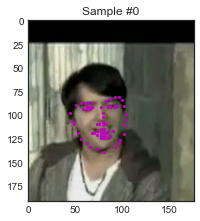

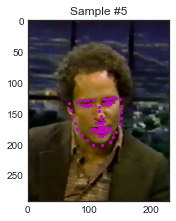

In [6]:
i = 0
sample = dataset_train_raw[i]
fkd.plots.plot_keypoints( sample['image'], sample['keypoints'], title = f"Sample #{i}" )

i = 5
sample = dataset_train_raw[i]
fkd.plots.plot_keypoints( sample['image'], sample['keypoints'], title = f"Sample #{i}" )

# <span style="color:crimson"> 3. Transformations to dataset </span>

Images above are not of the same size, and neural networks often expect images that are standardized; a fixed size, with a normalized range for color ranges and coordinates, and (for PyTorch) converted from numpy lists and arrays to Tensors.

Therefore, we will need to some pre-processing.
`facial_keypoints_detecter` uses four transforms:

-  ``fkd.preprocessing.Normalize``: To convert a color image to grayscale values with a range of [0,1] and normalize the keypoints to be in a range of about [-1, 1]
-  ``fkd.preprocessing.Rescale``: To rescale an image to a desired size.
-  ``fkd.preprocessing.RandomCrop``: To crop an image randomly.
-  ``fkd.preprocessing.ToTensor``: To convert numpy images to torch images.


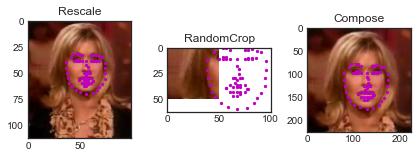

In [7]:
# Testing out some of these transforms >>
import matplotlib.pyplot as plt
rescale  = fkd.preprocessing.Rescale(100)
crop     = fkd.preprocessing.RandomCrop(50)
composed = fkd.preprocessing.Compose( [fkd.preprocessing.Rescale(250), fkd.preprocessing.RandomCrop(224)] )

# Applying the transforms to a sample image >>
i = 500
sample = dataset_train_raw[i]
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    fkd.plots.plot_keypoints( transformed_sample['image']
                            , transformed_sample['keypoints']
                            , title = type(tx).__name__
                            , axes = ax )

## <span style="color:SteelBlue"> Create the transformed dataset </span>
`fkd.preprocessing.Compose` is same as `torchvision.transforms.Compose`.

In [8]:
# Defining the data tranform >>
# order matters! i.e. rescaling should come before a smaller crop
data_transform = fkd.preprocessing.Compose( [ fkd.preprocessing.Rescale(250),
                                              fkd.preprocessing.RandomCrop(224),
                                              fkd.preprocessing.Normalize(),
                                              fkd.preprocessing.ToTensor() ] )

# Applying transforms >>
dataset_train_transformed = fkd.data.FacialKeypointsDataset( csv_file  = 'data/training_frames_keypoints.csv',
                                                             root_dir  = 'data/training/',
                                                             transform = data_transform )

In [9]:
# Printing some stats about the transformed data >>
print('Number of images: ', len(dataset_train_transformed))

# Making sure the sample tensors are the expected size >>
for i in range(5):
    sample = dataset_train_transformed[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])
4 torch.Size([1, 224, 224]) torch.Size([68, 2])


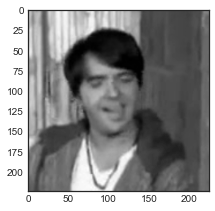

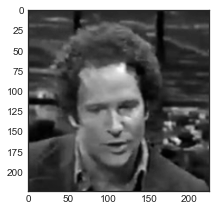

In [10]:
i = 0
sample = dataset_train_transformed[i]
fkd.plots.plot_output( sample['image'] )

i = 5
sample = dataset_train_transformed[i]
fkd.plots.plot_output( sample['image'] )

# <span style="color:crimson"> 4. Data augmentation </span>

Data augmentation in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model. \
In this project, we can rotate our dataset images slightly in both directions each to increase the size of ther dataset.

In [11]:
# Defining the data tranform >>
data_transform_rotate_clockwise = fkd.preprocessing.Compose( [
                                              fkd.preprocessing.Rescale(250),
                                              fkd.preprocessing.RandomCrop(224),
                                              fkd.preprocessing.Normalize(),
                                              fkd.preprocessing.Rotate(-20),
                                              fkd.preprocessing.Rescale(224),
                                              fkd.preprocessing.ToTensor()
                                            ] )

# Applying clockwise-rotation transform >>
dataset_rotate_clockwise = fkd.data.FacialKeypointsDataset( csv_file  = 'data/training_frames_keypoints.csv',
                                                             root_dir  = 'data/training/',
                                                             transform = data_transform_rotate_clockwise )

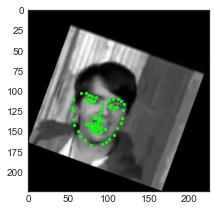

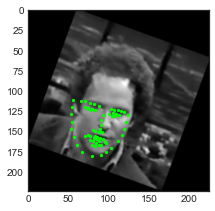

In [12]:
i = 0
sample = dataset_rotate_clockwise[i]
fkd.plots.plot_output( sample['image'], sample['keypoints'] )

i = 5
sample = dataset_rotate_clockwise[i]
fkd.plots.plot_output( sample['image'], sample['keypoints'] )

In [13]:
data_transform_rotate_anti_clockwise = fkd.preprocessing.Compose( [
                                              fkd.preprocessing.Rescale(250),
                                              fkd.preprocessing.RandomCrop(224),
                                              fkd.preprocessing.Normalize(),
                                              fkd.preprocessing.Rotate(20),
                                              fkd.preprocessing.Rescale(224),
                                              fkd.preprocessing.ToTensor()
                                            ] )

# Applying anti-clockwise-rotation transform >>
dataset_rotate_anti_clockwise = fkd.data.FacialKeypointsDataset( csv_file  = 'data/training_frames_keypoints.csv',
                                                             root_dir  = 'data/training/',
                                                             transform = data_transform_rotate_anti_clockwise )

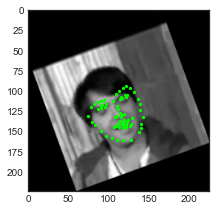

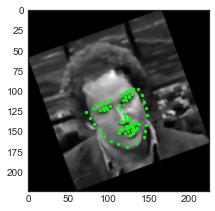

In [14]:
i = 0
sample = dataset_rotate_anti_clockwise[i]
fkd.plots.plot_output( sample['image'], sample['keypoints'] )

i = 5
sample = dataset_rotate_anti_clockwise[i]
fkd.plots.plot_output( sample['image'], sample['keypoints'] )

## <span style="color:SteelBlue"> Combining datasets </span>

`fkd.data.ConcatDataset` is same as `torch.utils.data.ConcatDataset`.

In [15]:
dataset_train = fkd.data.ConcatDataset([dataset_train_transformed, dataset_rotate_clockwise, dataset_rotate_anti_clockwise])
print('Number of images: ', len(dataset_train))

Number of images:  10386


### <span style="color:orange"> Ready to Train! </span>

Now that we have loaded and transformed our data, we are ready to build a neural network to train on this data. \
In the next notebook [Notebook 2](https://github.com/ShashankKumbhare/facial-keypoints-detecter/blob/main/2.%20Define%20the%20Network%20Architecture.ipynb), we will create a CNN for facial keypoint detection.

In [16]:
net = fkd.model.Net()
net.load_model('saved_models/20221102_01_3con_1fc_30epoch_batchSize10_cv2_lr0.0001_working.pt')

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc): Linear(in_features=86528, out_features=136, bias=True)
)

In [17]:
image = fkd.data.datasets.train.combined[0]["image"]
image_numpy = image.numpy()[0]
image_numpy.shape

(224, 224)

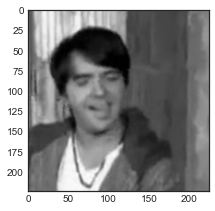

In [18]:
fkd.plots.plot_output(image)

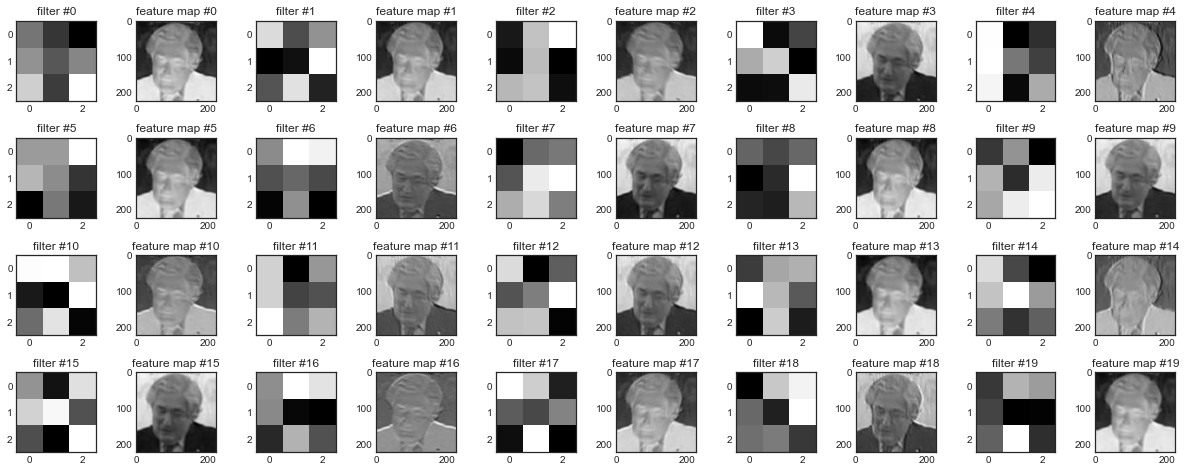

In [19]:
image   = fkd.data.datasets.test.preprocessed[0]["image"]
weights = net.conv1.weight.data
fkd.plots.plot_features ( image_gray_tensor  = image
                        , weights            = weights
                        , n_features_to_plot = 20
                        , figsizeScale       = 0.5 )

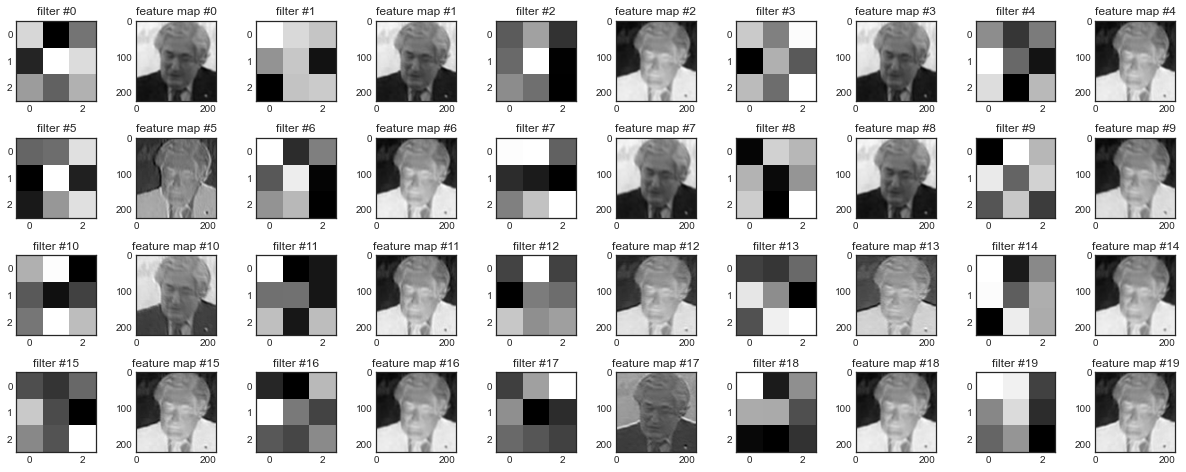

In [20]:
image   = fkd.data.datasets.test.preprocessed[0]["image"]
weights = net.conv2.weight.data
fkd.plots.plot_features ( image_gray_tensor  = image
                        , weights            = weights
                        , n_features_to_plot = 20
                        , figsizeScale       = 0.5 )

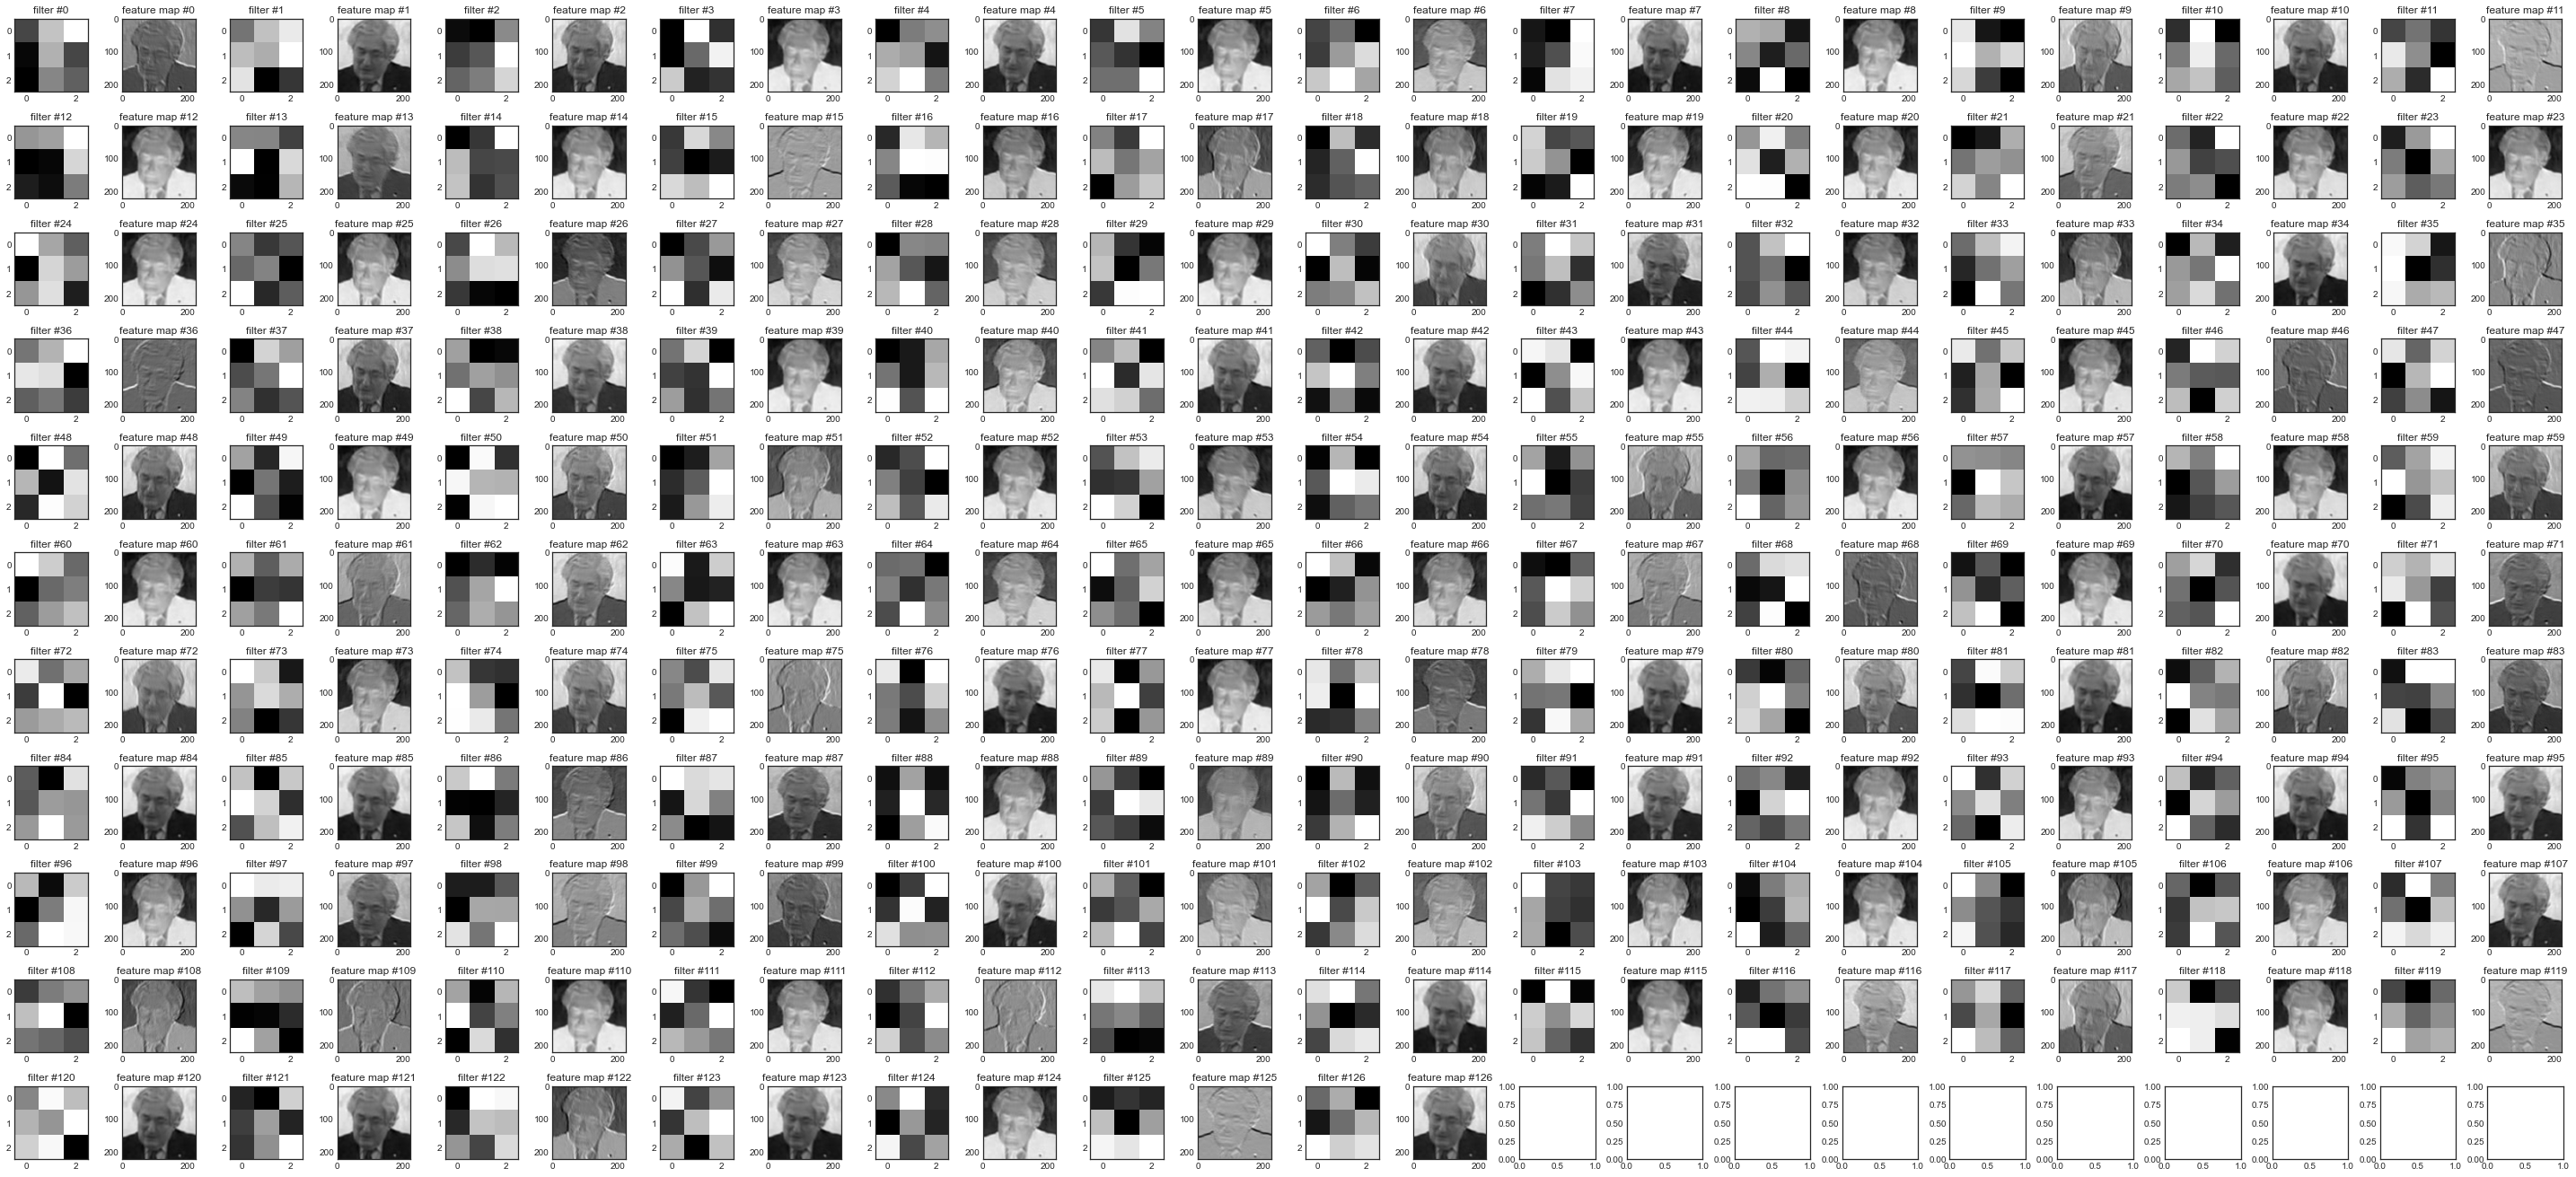

In [22]:
image   = fkd.data.datasets.test.preprocessed[0]["image"]
weights = net.conv3.weight.data
fkd.plots.plot_features ( image_gray_tensor  = image
                        , weights            = weights
                        , n_features_to_plot = 127
                        , figsizeScale       = 0.5 )